# Loading Packages & Initialization

reference : https://gist.github.com/mertedali/ab7078b9c29dea18c72525239d636b96

In [2]:
rm(list=ls())

library(data.table)
library(tidyverse)
library(rJava)
library(RNetLogo)

library(lhs) # For maximin Latin hypercube sampling
library(ggplot2)
library(caret)
library(randomForest)
library(factoextra)
library(e1071)
library(TSrepr) # for evaluating predictive power

require(gridExtra)

options(warn = -1)

In [3]:
# Select if data generation is wanted
GenerateTTData <- 0

In [4]:
Is_Headless <- 1
nl.model <- "Segregation_Dummy"

nl.path <- "C:/Program Files/NetLogo 6.0.4/app"
model.path <- paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/",nl.model,".nlogo")

if (Is_Headless == 0){
    NLStart(nl.path, gui = TRUE,nl.jarname='netlogo-6.0.4.jar')
    NLLoadModel (model.path)
    } else {
    NLStart(nl.path, gui = FALSE,nl.jarname='netlogo-6.0.4.jar')
    NLLoadModel (model.path)
    
    #NLStart(nl.path, gui = FALSE,nl.jarname='netlogo-6.0.4.jar', nl.obj = nl.model)
    #NLLoadModel (model.path, nl.obj = nl.model )
    }

# Model Parameters & Functions

## Set model parameters

In [5]:
set.seed(1)

## Set model parameters
 # Number of replications for each instance
nofrep = 1     

# Number of iterations
numiter = 10
 # order feature names according to their definition order in run_model
feature_names = c("density","%-similar-wanted","budget-multiplier-dummy","density-multiplier-dummy","noise-dummy","tick-limit")  
 # 
output_name = c("percent-similar")

 # Number of input parameters of the agent-based model
nofparams = length(feature_names)      

# set RF parameters
ntree = 400
mtry = 2

## Set user parameters

In [6]:
error_type = "RMSE" # MAPE, BIAS

# choose the uncertainty measure
selection_metric <- "sd" #, "range" 

unlabeled_ins = 700 
test_ins = 400
train_ins_oneshot = 700
train_ins_Ad = 200

# Set selection parameters
selected_ins = 5 #nofinstancesWillbeSelected in each step

# Set elimination parameters
h <- 1 # number of variables eliminated in each step


## Define functions

### run_model

In [7]:
#run_model <- function(feature_names,feature_values){ # both should be in character list format
run_model <- function(feature_values){ # both should be in character list format

    
    k = length(feature_names)    
    for(i in 1:k){
        NLCommand(paste0("set ",feature_names[i]," ",feature_values[i]))      
    }
    NLCommand("setup")
    NLDoCommand(100, "go") 
    result <- NLReport(output_name)
    return(result)   
}

### run_replicas

In [8]:
#run_replicas <- function(nofrep,feature_names,feature_values) {
run_replicas <- function(nofrep,feature_values) {
    replicas = matrix(NA, ncol = nofrep, nrow = 1) # Save the result of each replication
    for(i in 1:nofrep){
     #   replicas[i]= run_model(feature_names,feature_values)
        replicas[i]= run_model(feature_values)
    }
    aggregated_result = mean(replicas)
    return(aggregated_result)
}

### run_ABM

In [9]:
#run_ABM = function(nofrep,nofinstances,unlabeledset,featurenames = feature_names){
run_ABM = function(nofrep,nofinstances,unlabeledset){
   #unlabeledset = setcolorder(unlabeledset,featurenames) 
   unlabeledset = setcolorder(unlabeledset,feature_names) 
   for(i in 1:nofinstances){
        #unlabeledset[i, output :=  run_replicas(nofrep,featurenames, as.matrix(unlabeledset[i,]))]    
        unlabeledset[i, output :=  run_replicas(nofrep, as.matrix(unlabeledset[i,]))] 
    } 
    return(unlabeledset)
}


### error functions

In [10]:
#error functions on test data
rmse_func <- function(actual, predicted){
    error = predicted - actual
    return(sqrt(mean(error^2)))
}

mape_func <- function(actual,predicted){
    return( (abs(actual - predicted)/ actual)*100 )
}

bias_func <- function(actual,predicted){
    return( (actual - predicted)/ actual )
}

#error functions on train data
obb_error_func <- function(model){
   if(model$type == "regression"){
        oob_error = model$mse[model$ntree] 
    }else if(model$type == "classification"){
        oob_error = model$err.rate 
    } 
    return(oob_error)
}


### get_test_predictions

In [100]:
# prediction functions
get_test_predictions <- function(model,testset,errortype){
    
    predictedLabels <- predict(model, testset)
    predictedLabels <- cbind(testset,predictedLabels)
    setnames(predictedLabels, "predictedLabels","pred_output")

    output_variables = colnames(select(predictedLabels, contains("output")))
    # output_variables[1] = true output
    # output_variables[2] = predicted output
    
    #output_variables = colnames(predictedLabels[,1:(ncol(predictedLabels) - 2)])
    
    if(error_type == "MAPE"){
        predictedLabels[,MAPE := mapply(function(x,y) mape_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "RMSE"){
        predictedLabels[,RMSE := mapply(function(x,y) rmse_func(x,y),get(output_variables[1]),get(output_variables[2]))]
          }
    if(error_type == "BIAS"){
        predictedLabels[,BIAS := mapply(function(x,y) bias_func(x,y),get(output_variables[1]),get(output_variables[2]))]
           } 
                                  
     output_variables_1 = predictedLabels[,get(output_variables[1]), with = TRUE]
     output_variables_2 = predictedLabels[,get(output_variables[2]), with = TRUE]
    
     performance_temp = matrix(c(1:3), nrow = 1, ncol = 3)
     performance_temp[1] =  mae(output_variables_1 , output_variables_2)
     performance_temp[2] = rmse(output_variables_1 , output_variables_2)
     performance_temp[3] = mape(output_variables_1 , output_variables_2)
    
    return(list(predictedLabels,performance_temp,output_variables))
    
} 

### sample_selection

In [105]:
# Adaptive sample selection function with an uncertainty measure depending on "selection_metric"
sample_selection <- function(selected_ins,unlabeled_set,model){
    ind_pred <- t(predict(model, unlabeled_set,predict.all = TRUE)$individual) %>%
                data.table() # predictions by each tree in the forest
    ind_pred_eval = data.table()
    
    # standard deviation calculation
    s_dev = sapply(ind_pred, sd) %>% data.table()
    setnames(s_dev,".","sd")
    ind_pred_eval = cbind(ind_pred_eval,s_dev)
    
    # range calculation
    range = sapply(ind_pred, range) %>% t() %>% data.table()
    range = range[,.(range = abs(range[,1] - range[,2]))]
    setnames(range,"range.V1","range")
    ind_pred_eval = cbind(ind_pred_eval,range)
        
    ind_pred_eval[,idx := 1:.N]
    
    if(selection_metric == "sd") {
      ind_pred_eval = ind_pred_eval[order(-sd)][1:selected_ins]
    }else if(selection_metric == "range"){
      ind_pred_eval = ind_pred_eval[order(-range)][1:selected_ins]
    }
    
    unlabeled_set[,idx := 1:.N]    
    train_candidates = unlabeled_set[ind_pred_eval$idx]
    
    return(train_candidates)
}

### random_sample_selection

In [13]:
# Random sample selection
random_sample_selection <- function(selected_ins,unlabeled_set){
  
    unlabeled_set[,idx := 1:.N]
    
    train_candidate_idx = sample(unlabeled_set$idx, selected_ins, replace = FALSE, prob = NULL)   
    train_candidates = unlabeled_set[idx %in% train_candidate_idx]
    
    return(train_candidates)
}

### get_variable_importance

In [14]:
get_variable_importance <- function(model){
    importances <- importance(model, type = 1, scale = FALSE)
    selected.vars <- order(importances, decreasing = TRUE)
    ranked_features = feature_names[selected.vars]
    ordered.importances <- importances[selected.vars]
    
    return(ranked_features)
}                      

### feature_elimination

In [178]:
feature_elimination <- function(h,total_numof_eliminated_vars,ranked_features){ 
    numof_columns_left = length(ranked_features) - (total_numof_eliminated_vars + h)
    columns_left = ranked_features[1:numof_columns_left]
    
    eliminated_columns = setdiff((length(ranked_features) - total_numof_eliminated_vars), numof_columns_left)
    eliminated_columns = ranked_features[eliminated_columns]
    
    # update total_numof_eliminated_vars
    total_numof_eliminated_vars = length(ranked_features) - length(columns_left)
    
    return(list(columns_left,total_numof_eliminated_vars,h,eliminated_columns))
 }

# Generate Unlabeled Data Pool

## Latin hyper cube sampling

In [16]:
if(GenerateTTData == 1){
    unlabeled_pool = as.data.table(maximinLHS(n = unlabeled_ins, k = nofparams, dup = 5))
    
    unlabeled_pool$V1 = qunif(unlabeled_pool$V1, 10, 90) 
    unlabeled_pool$V2 = qunif(unlabeled_pool$V2, 10, 90)
    unlabeled_pool$V3 = qunif(unlabeled_pool$V3, 1, 10) 
    unlabeled_pool$V4 = qunif(unlabeled_pool$V4, 0.01, 1)    
    unlabeled_pool$V5 = qunif(unlabeled_pool$V5, 0.00001, 0.0001) 
    unlabeled_pool$V6 = qunif(unlabeled_pool$V6, 90, 110)  
    
    setnames(unlabeled_pool, c(paste0("V",1:nofparams)), feature_names)
    
    unlabeled_pool[,idx := 1:.N]
        
    fwrite(unlabeled_pool, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/unlabeled_pool_",Sys.Date(),".csv"))
}else{
    unlabeled_pool <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/unlabeled_pool_2019-12-20.csv")   
}

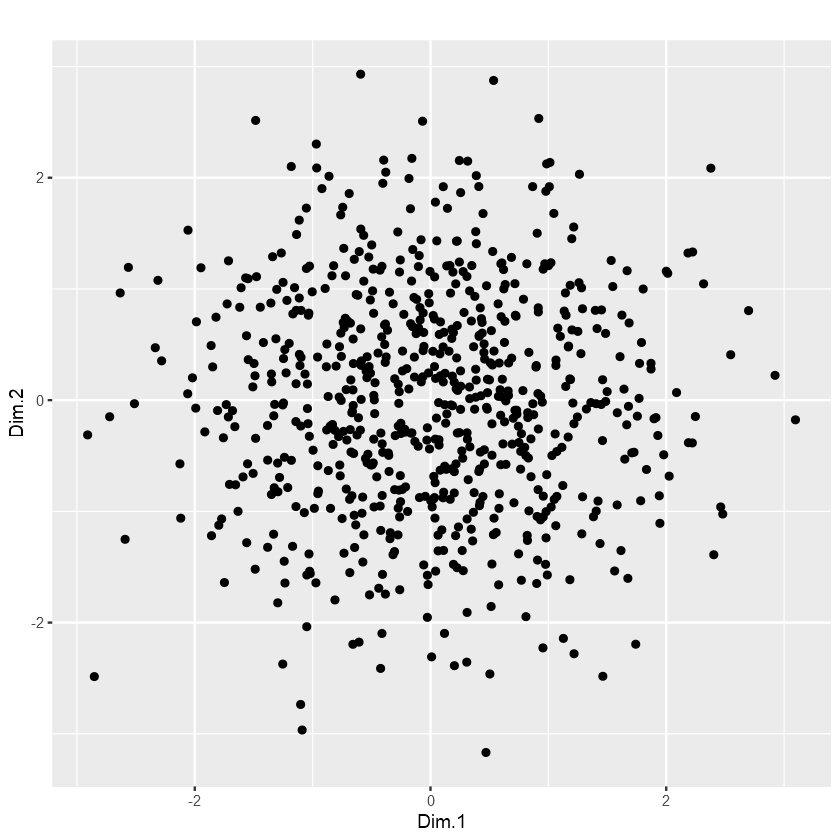

In [17]:
pca_unlabeled_pool <- princomp(unlabeled_pool[,-c("idx")], cor = TRUE, scores = TRUE)
pca_unlabeled_pool_components <- get_pca_ind(pca_unlabeled_pool)
p_unlabeled_pool <- ggplot(data = data.table(pca_unlabeled_pool_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
                    geom_point() +
                    labs( title = "") 
p_unlabeled_pool


# Generate Test Set

In [18]:
if(GenerateTTData == 1){
    test_set <- head(unlabeled_pool,test_ins)
    
    ################## Buraya variale'ların datatipine göre bir şeyler yazılabilir
    test_set$density                    = runif(test_ins, 10, 90) 
    test_set$`%-similar-wanted`         = runif(test_ins, 10, 90) 
    test_set$`budget-multiplier-dummy`  = runif(test_ins, 1, 10) 
    test_set$`density-multiplier-dummy` = runif(test_ins, 0.01, 1) 
    test_set$`noise-dummy`              = runif(test_ins, 0.00001, 0.0001) 
    test_set$`tick-limit`               = runif(test_ins, 90, 110) 
    
    test_set[,c("idx"):= NULL]
      
    print(paste0("ABM run start time : ",Sys.time()))
    test_set = run_ABM(nofrep,test_ins,test_set) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))
    
    fwrite(test_set, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/test_set_",Sys.Date(),".csv"))
}else{
    test_set <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/test_set_2019-12-20.csv")  
}

10 * 10 ~ 1 min
100 * 10 ~ 14 min
900 * 10 ~ 09:16 -- 2019-12-03 07:54:10 +03"

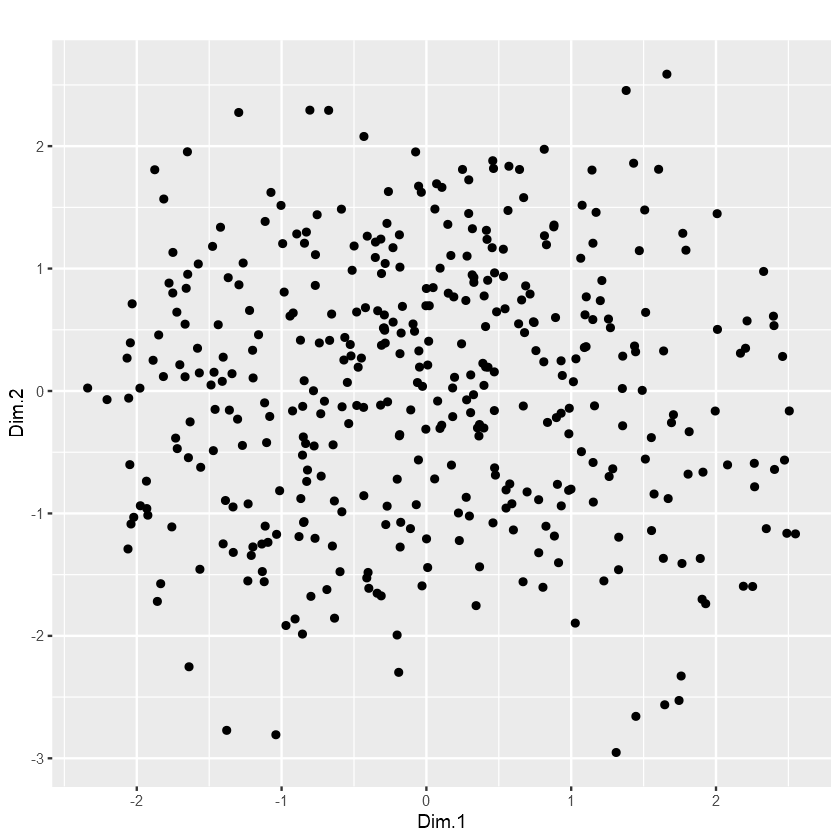

In [19]:
pca_test_set <- princomp(test_set, cor = TRUE, scores = TRUE)
pca_test_set_components <- get_pca_ind(pca_test_set)
p_test_set <- ggplot(data = data.table(pca_test_set_components$coord[,1:2]), aes(x = Dim.1, y = Dim.2)) +
                    geom_point() +
                    labs( title = "") 
p_test_set

# Benchmark : One-shot sampling, No feature elimination

## Generate Training Set

Select a very big data pool ( nofinstances should be very high ) , like 1000

In [21]:
if(GenerateTTData == 1){
    LHSample = as.data.table(maximinLHS(n = train_ins_oneshot, k = nofparams, dup = 5))
    
    LHSample$V1 = qunif(LHSample$V1, 10, 90) 
    LHSample$V2 = qunif(LHSample$V2, 10, 90) 
    LHSample$V3 = qunif(LHSample$V3, 1, 10) 
    LHSample$V4 = qunif(LHSample$V4, 0.01, 1)    
    LHSample$V5 = qunif(LHSample$V5, 0.00001, 0.0001) 
    LHSample$V6 = qunif(LHSample$V6, 90, 110)  
    
    setnames(LHSample, c(paste0("V",1:nofparams)), feature_names)
   
    LHSample$output <- 0.00
    
    print(paste0("ABM run start time : ",Sys.time()))
    LHSample = run_ABM(nofrep,train_ins_oneshot,LHSample) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))
    
    fwrite(LHSample, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Data_",Sys.Date(),".csv"))
    
}else{
    LHSample <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Data_2019-12-20.csv")
}

In [22]:
one_shot_data = copy(LHSample)

### Visualization

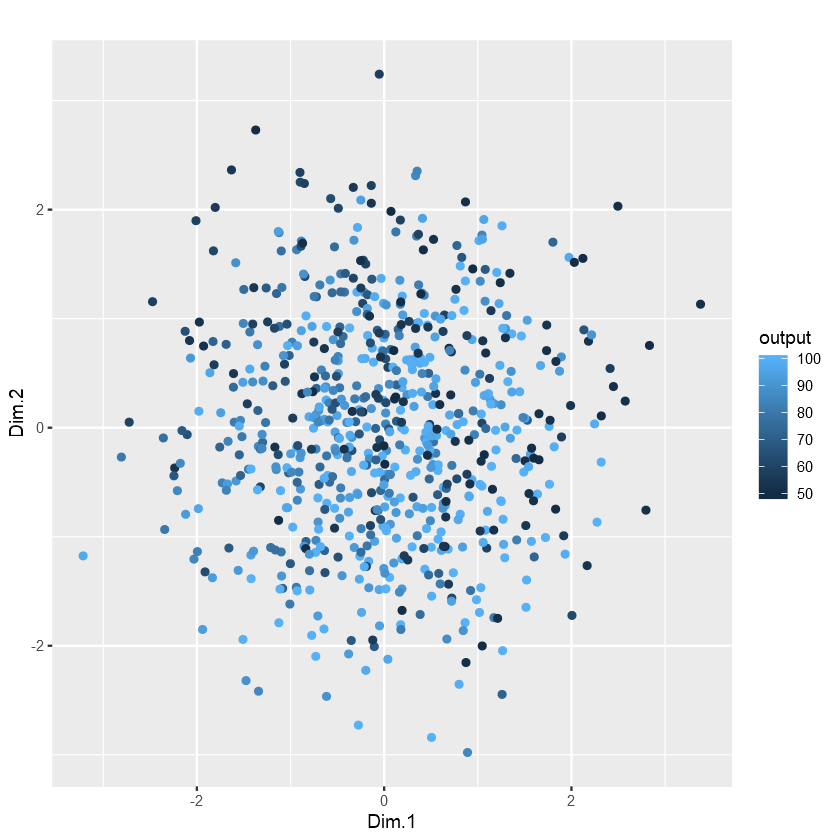

In [23]:
pca_LHSample <- princomp(LHSample[,.SD, .SDcols = !c("output")], cor = TRUE, scores = TRUE)

#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_LHSample_components <- get_pca_ind(pca_LHSample)
pca_LHSample_components <-cbind(pca_LHSample_components$coord[,1:2],LHSample[,.SD, .SDcols = c("output")])
p_LHSample <- ggplot(data = pca_LHSample_components, aes(x = Dim.1, y = Dim.2)) +
             geom_point(aes(colour = output)) +
             labs( title = "", legend = "output") 
p_LHSample

## Train & Test Metamodel

In [24]:
model_oneshot <- randomForest(x = LHSample[, -c("output")], y = LHSample$output, importance = TRUE,ntree = ntree, mtry = mtry)
model_oneshot


Call:
 randomForest(x = LHSample[, -c("output")], y = LHSample$output,      ntree = ntree, mtry = mtry, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 400
No. of variables tried at each split: 2

          Mean of squared residuals: 28.61753
                    % Var explained: 90.58

In [25]:
obb_error_oneshot <- obb_error_func(model_oneshot)

In [ ]:
#OBB_pred = cbind(LHSample$output,model_oneshot$predicted)
#names(OBB_pred) <- c("actual","predicted")

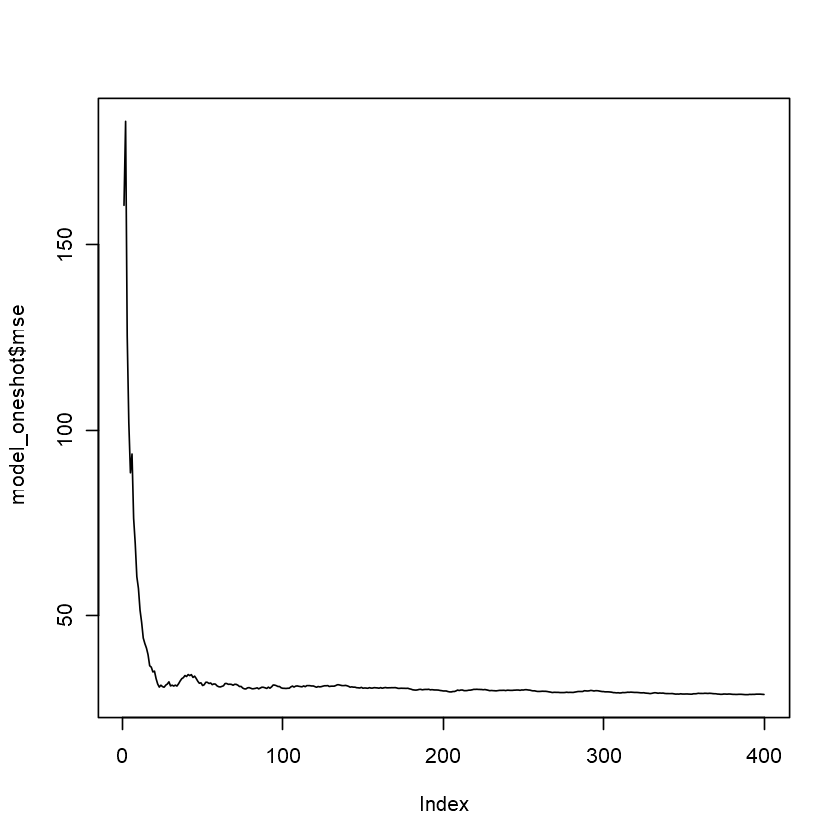

In [26]:
plot(model_oneshot$mse, type="l")

In [27]:
test_prediction_oneshot = get_test_predictions(model_oneshot,test_set,error_type)
predictedLabels_oneshot = test_prediction_oneshot[[1]]

performance_table_oneshot = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric())

performance_table_temp = test_prediction_oneshot[[2]]
performance_table_oneshot = rbind(performance_table_oneshot,performance_table_temp, use.names = FALSE)
rm(performance_table_temp)   

output_variables = test_prediction_oneshot[[3]]    


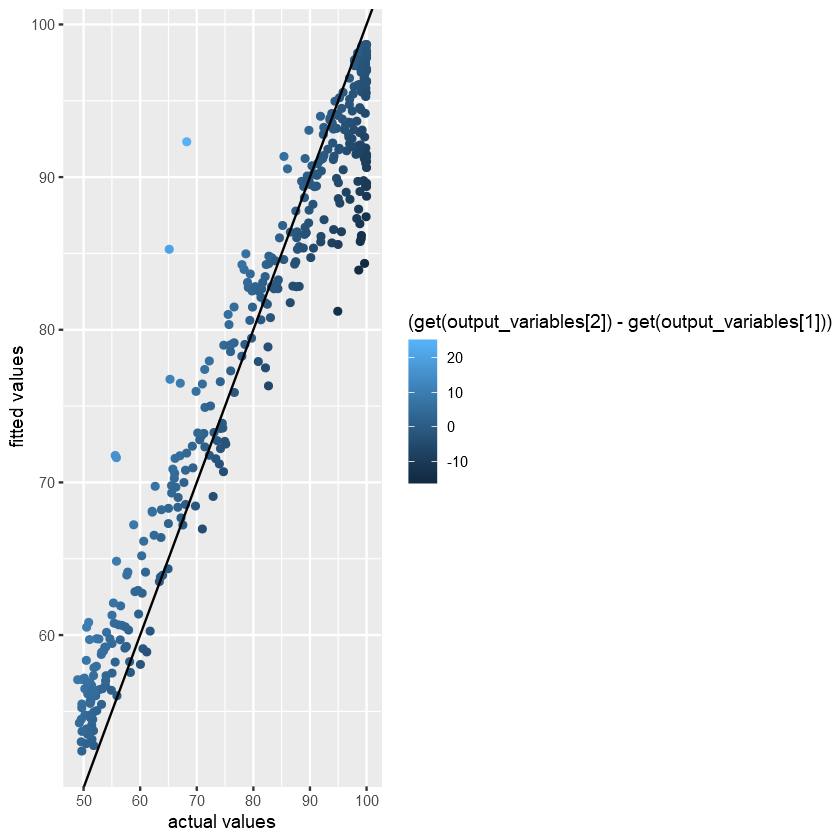

In [28]:
p_oneshot <- ggplot(predictedLabels_oneshot,aes(x = get(output_variables[1]), y = get(output_variables[2]), color = (get(output_variables[2]) - get(output_variables[1])))) +
            geom_point() +
            geom_abline() +
            xlab("actual values") +
            ylab("fitted values")

p_oneshot

# Random Sampling & No Feature Elimination

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [29]:
if(GenerateTTData == 1){
   
    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
    
    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90)
    LHSample_Ad$V3 = qunif(LHSample_Ad$V3, 1, 10) 
    LHSample_Ad$V4 = qunif(LHSample_Ad$V4, 0.01, 1)    
    LHSample_Ad$V5 = qunif(LHSample_Ad$V5, 0.00001, 0.0001) 
    LHSample_Ad$V6 = qunif(LHSample_Ad$V6, 90, 110) 
    
    setnames(LHSample_Ad, c(paste0("V",1:nofparams)), feature_names)
    LHSample_Ad$output <- 0.00
    
    print(paste0("ABM run start time : ",Sys.time()))
    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
    print(paste0("ABM run end time : ",Sys.time()))
    
    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))

}else{
    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_2019-12-20.csv")
}

In [30]:
adaptive_initial_data = copy(LHSample_Ad)

## Train & Test Metamodel

In [31]:
# Record train candidates
train_candidates_table = matrix(c(1:ncol(LHSample_Ad) ), nrow = 0, ncol = ncol(LHSample_Ad) )
colnames(train_candidates_table) <- colnames(LHSample_Ad)
colnames(train_candidates_table)[colnames(train_candidates_table) == "output"] <- "idx"

# Record model performances
performance_table = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric()  )

#error_type = "mape"  
predictedLabels_table = copy(test_set)

In [32]:
iter = 1

while(iter < numiter){ 
    
    print(iter)

    trainx = LHSample_Ad[,.SD, .SDcols = feature_names]
    trainy = LHSample_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
    
     if(iter == 1){ # keep just as info
         ranked_features = get_variable_importance(model_Sub)
     }                      
         
    
    if(iter == 1){
        obb_error <- as.data.table(obb_error_func(model_Sub)) 
        obb_error$iter <- 1 
        setnames(obb_error,"V1","obb_error")
    }else{
         ## OOB Error & Test Error 
        obb_error_Sub <- as.data.table(obb_error_func(model_Sub)) 
        obb_error_Sub$iter <- iter 
        obb_error <- rbind(obb_error,obb_error_Sub, use.names = FALSE)
        rm(obb_error_Sub)
    }
 
    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # record the general test errors
    performance_table_temp = test_predictions_Sub[[2]]
    performance_table_temp[[1]] = iter
    performance_table = rbind(performance_table,performance_table_temp, use.names = FALSE)
    rm(performance_table_temp)   
    
    output_variables = test_predictions_Sub[[3]]          

    # Sample from unlabeled data
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = random_sample_selection(selected_ins,unlabeled_set)
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    
    # Run ABM to label train candidates
#  train_candidates = as.data.table(train_candidates) 
    print(paste0("ABM train_candidate run start time : ",Sys.time()))
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    print(paste0("ABM train_candidate run end time : ",Sys.time()))
    
    if(iter == 1){
        train_candidates_table <- copy(train_candidates)
        train_candidates_table$iter <- iter
    }else{
        train_candidates_temp <- copy(train_candidates)
        train_candidates_temp$iter <- iter
        
        train_candidates_table <- rbindlist(list(train_candidates_table,train_candidates_temp), use.names=TRUE)
        rm(train_candidates_temp)
    }

    # Add new data to train data
    LHSample_Ad = rbind(LHSample_Ad,train_candidates[,-c("idx")])

    iter = iter + 1
}

# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!


[1] 1
[1] "ABM train_candidate run start time : 2020-01-06 23:45:56"
[1] "ABM train_candidate run end time : 2020-01-06 23:46:07"
[1] 2
[1] "ABM train_candidate run start time : 2020-01-06 23:46:08"
[1] "ABM train_candidate run end time : 2020-01-06 23:46:15"
[1] 3
[1] "ABM train_candidate run start time : 2020-01-06 23:46:15"
[1] "ABM train_candidate run end time : 2020-01-06 23:46:25"
[1] 4
[1] "ABM train_candidate run start time : 2020-01-06 23:46:25"
[1] "ABM train_candidate run end time : 2020-01-06 23:46:34"
[1] 5
[1] "ABM train_candidate run start time : 2020-01-06 23:46:34"
[1] "ABM train_candidate run end time : 2020-01-06 23:46:39"
[1] 6
[1] "ABM train_candidate run start time : 2020-01-06 23:46:40"
[1] "ABM train_candidate run end time : 2020-01-06 23:46:44"
[1] 7
[1] "ABM train_candidate run start time : 2020-01-06 23:46:45"
[1] "ABM train_candidate run end time : 2020-01-06 23:46:49"
[1] 8
[1] "ABM train_candidate run start time : 2020-01-06 23:46:50"
[1] "ABM train_candid

In [33]:
# Final records
FinalTrainData_Rd = copy(LHSample_Ad)
performance_table_Rd = copy(performance_table)
train_candidates_table_Rd  = copy(train_candidates_table)
predictedLabels_table_Rd = copy(predictedLabels_table)
obb_error_Rd = copy(obb_error)

In [34]:
# show results
nrow(FinalTrainData_Rd)
performance_table_Rd 
train_candidates_table_Rd  
head(predictedLabels_table_Rd)
obb_error_Rd

[1] 245

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,6.243684,7.849467,8.775010
2,6.489823,8.078384,9.160258
3,6.146981,7.802160,8.706093
4,6.295246,7.893528,8.832898
5,5.949544,7.553656,8.394054
6,5.797829,7.355742,8.204810
7,5.939429,7.580542,8.411968
8,5.674811,7.207851,8.060459
9,5.628196,7.219857,7.980234


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
71.28812,51.46540,2.140200,0.24978951,3.648172e-05,94.55682,57,94.10724,1
25.87072,71.93649,7.551367,0.59146457,2.936624e-05,101.52524,114,100.00000,1
30.79384,40.94736,5.057692,0.54736048,5.046197e-05,107.57766,145,93.16411,1
81.37530,81.28151,9.289525,0.51114474,8.039323e-05,93.96923,261,52.05851,1
55.34717,45.92310,5.961940,0.33538086,7.345333e-05,99.55940,669,89.48027,1
33.44655,49.33781,5.674009,0.45077405,3.686240e-05,101.57902,98,91.88783,2
11.05616,55.85664,8.086544,0.15965713,1.407402e-05,93.29313,432,100.00000,2
88.02753,62.65820,2.616159,0.55048310,8.636069e-05,92.56735,433,98.49991,2
54.31753,19.00496,9.117432,0.90169032,2.125501e-05,108.20355,483,59.66311,2


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,...,pred_output_5,RMSE_5,pred_output_6,RMSE_6,pred_output_7,RMSE_7,pred_output_8,RMSE_8,pred_output_9,RMSE_9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89.80781,63.22101,9.559364,0.7183232,9.772682e-05,94.85461,98.62087,79.87295,18.747913,78.55541,...,82.08430,16.5365673,82.35009,16.270773,81.58482,17.0360461,81.82684,16.7940258,79.83516,18.785709
65.95304,27.51730,1.113979,0.4611830,4.533282e-05,91.35383,66.09090,74.45472,8.363821,76.46425,...,74.42612,8.3352188,74.73937,8.648474,75.09732,9.0064248,75.00550,8.9145997,73.77780,7.686902
65.63748,42.72006,7.460221,0.2498248,4.748342e-05,106.60832,86.53810,89.91434,3.376239,90.03017,...,89.22968,2.6915827,89.64335,3.105246,89.41840,2.8802986,89.00473,2.4666331,89.25080,2.712696
49.08474,53.36187,1.029111,0.3209241,2.648540e-05,95.31602,97.06720,92.35617,4.711029,91.85922,...,94.20514,2.8620583,92.13619,4.931012,91.52463,5.5425725,93.09872,3.9684752,93.83714,3.230062
82.31666,32.86349,9.937437,0.7424780,9.336225e-05,91.00066,73.99356,71.20232,2.791248,71.98478,...,72.99749,0.9960746,75.08439,1.090827,74.64074,0.6471731,74.82109,0.8275268,75.16830,1.174734
59.08719,22.26741,5.281372,0.7351098,1.573031e-05,98.78114,63.67668,70.01950,6.342820,70.40217,...,69.42558,5.7489027,69.88939,6.212715,70.34057,6.6638917,69.40909,5.7324083,68.65960,4.982921


obb_error,iter
<dbl>,<dbl>
68.52227,1
70.82629,2
64.58808,3
67.13974,4
64.70137,5
65.32073,6
66.86971,7
59.86918,8
60.54063,9


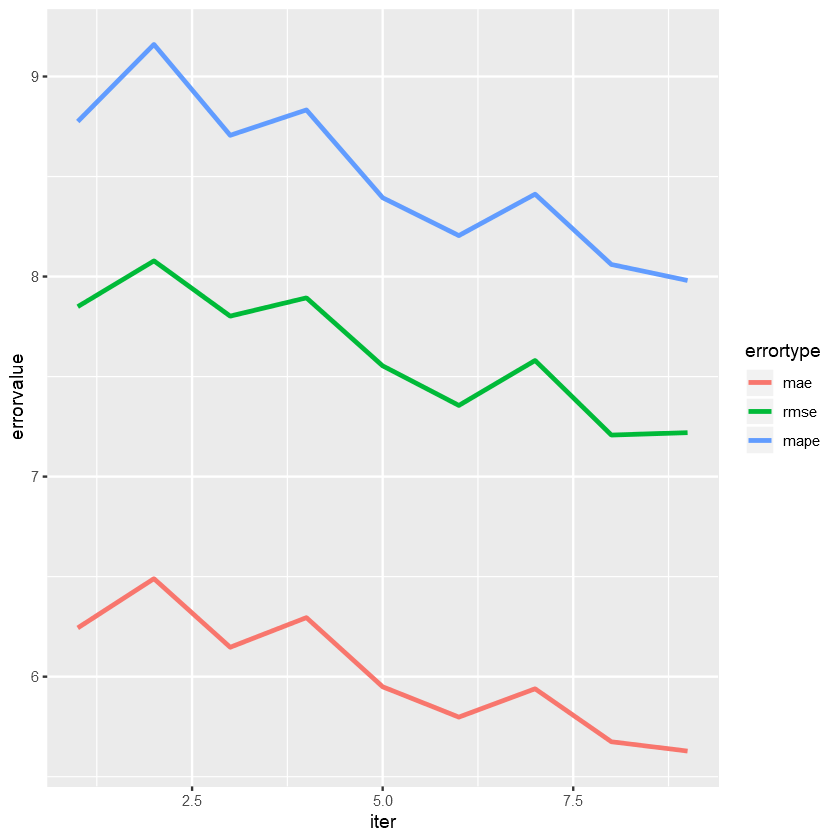

In [35]:
performance_molten_Rd <- melt(data = performance_table_Rd
                             , id.vars = 'iter')
setnames(performance_molten_Rd, c("variable","value"),c("errortype","errorvalue"))
p_Rd = ggplot(performance_molten_Rd, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
          geom_line(lwd=1)
p_Rd

# Adaptive Sampling & No Feature Elimination

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [36]:
LHSample_Ad = copy(adaptive_initial_data)

In [ ]:
#if(GenerateTTData == 1){
#   
#    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
#    
#    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
#    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90) 
#    setnames(LHSample_Ad, c("V1","V2"), feature_names)
#    LHSample_Ad$output <- 0.00
#    
#    paste0("ABM run start time : ",Sys.time())
#    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
#    paste0("ABM run end time : ",Sys.time())
#    
#    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))
#
#}else{
#    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
#    LHSample_Ad <- head(LHSample_Ad[`%-similar-wanted` < 90],300)
#
#}

### Visualization

In [37]:
pca_LHSample_Ad <- princomp(LHSample_Ad[,-c("output")], cor = TRUE, scores = TRUE)

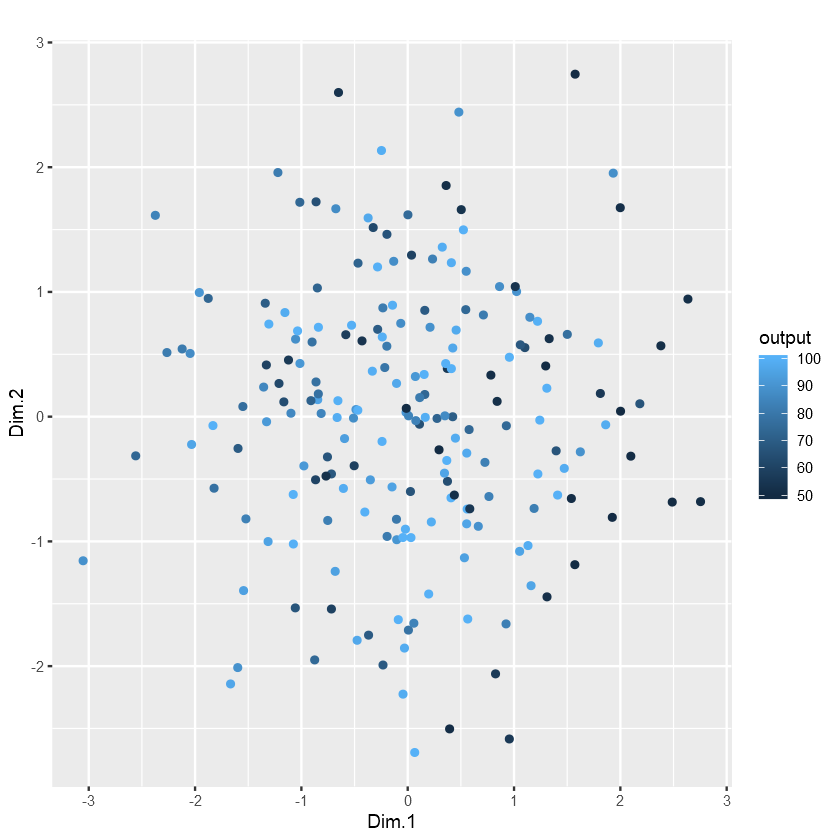

In [38]:
#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_LHSample_Ad_components <- get_pca_ind(pca_LHSample_Ad)
pca_LHSample_Ad_components <-cbind(pca_LHSample_Ad_components$coord[,1:2],LHSample_Ad[,c("output")])
p_LHSample_Ad <- ggplot(data = pca_LHSample_Ad_components, aes(x = Dim.1, y = Dim.2)) +
                     geom_point(aes(colour = output)) +
                     labs( title = "", legend = "output") 
p_LHSample_Ad

## Train & Test Metamodel

In [39]:
# Record train candidates
train_candidates_table = matrix(c(1:ncol(LHSample_Ad) ), nrow = 0, ncol = ncol(LHSample_Ad) )
colnames(train_candidates_table) <- colnames(LHSample_Ad)
colnames(train_candidates_table)[colnames(train_candidates_table) == "output"] <- "idx"

# Record model performances
performance_table = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric()  )
# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric())

#error_type = "mape"  
predictedLabels_table = copy(test_set)

In [62]:
iter = 1

while(iter < numiter){ 
    
    print(iter)

    trainx = LHSample_Ad[,.SD, .SDcols = feature_names]
    trainy = LHSample_Ad$output
    
    # Train the model
    model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
    assign(paste0("model_Sub_",iter),model_Sub)
    
     if(iter == 1){ # keep just as info
         ranked_features = get_variable_importance(model_Sub)
     }                      
         
    
    obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub)),use.names=FALSE)

    # test the model on test set
    test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
    predictedLabels_Sub = test_predictions_Sub[[1]]
    setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))    
    predictedLabels_table = cbind(predictedLabels_table,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
    
    # record the general test errors
    performance_table = rbind(performance_table,data.table(iter,test_predictions_Sub[[2]]), use.names = FALSE)
    
    
    output_variables = test_predictions_Sub[[3]]          

    # Sample from unlabeled data
    unlabeled_set <- copy(unlabeled_pool)
    train_candidates = sample_selection(selected_ins,unlabeled_set,model_Sub)
    # Eliminate train candidates from the unlabeled pool
    unlabeled_pool = unlabeled_pool[- train_candidates$idx]
    rm(unlabeled_set)
    
    # Run ABM to label train candidates
#  train_candidates = as.data.table(train_candidates) 
    paste0("ABM train_candidate run start time : ",Sys.time())
    train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
    paste0("ABM train_candidate run end time : ",Sys.time())
    
    if(iter == 1){
        train_candidates_table <- copy(train_candidates)
        train_candidates_table$iter <- iter
    }else{
        train_candidates_temp <- copy(train_candidates)
        train_candidates_temp$iter <- iter
        
        train_candidates_table <- rbindlist(list(train_candidates_table,train_candidates_temp), use.names=TRUE)
        rm(train_candidates_temp)
    }

    # Add new data to train data
    LHSample_Ad = rbind(LHSample_Ad,train_candidates[,-c("idx")])

    iter = iter + 1
}

# plot koy her iteration'da göstersin.
#setcolorder(data,variableorder) ################# bunu bi yerlere koyman gerekebilir, dikkat!!


[1] 9


[1] "ABM train_candidate run start time : 2020-01-07 00:11:44"

[1] "ABM train_candidate run end time : 2020-01-07 00:11:49"

In [63]:
# Final records
FinalTrainData_Ad = copy(LHSample_Ad)
performance_table_Ad = copy(performance_table)
train_candidates_table_Ad  = copy(train_candidates_table)
predictedLabels_table_Ad = copy(predictedLabels_table)
obb_error_Ad = copy(obb_error)

In [64]:
nrow(FinalTrainData_Ad)
performance_table_Ad
train_candidates_table_Ad
head(predictedLabels_table_Ad)
obb_error_Ad

[1] 250

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,6.170450,7.744541,8.668863
2,6.026021,7.479324,8.517426
3,6.041887,7.356840,8.501406
4,5.636191,6.948812,7.920448
5,5.700652,6.994770,8.072095
6,5.776656,7.106889,8.133422
7,5.431424,6.649135,7.599942
8,5.375310,6.526674,7.546608
9,5.175032,6.342997,7.299479


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
13.16295,81.92370,4.918442,0.90748670,5.156864e-05,108.65117,323,100.00000,1
59.26529,75.16035,2.470868,0.39089915,3.816702e-05,105.17168,56,57.40698,1
10.41457,89.91221,1.036082,0.57597604,7.662668e-05,109.04119,635,100.00000,1
13.37395,88.40317,3.449100,0.07868366,8.048873e-05,108.15717,510,100.00000,1
56.96093,81.45353,1.528351,0.25268715,7.777971e-05,98.44494,342,51.96677,1
66.01900,88.67981,1.050862,0.05744754,9.129029e-05,109.94240,627,49.57199,2
59.86070,74.54927,3.691402,0.69880877,4.577660e-05,102.02923,343,99.84021,2
13.28657,82.76549,2.911650,0.85907750,9.799145e-05,93.38701,644,100.00000,2
34.11864,89.13136,1.133751,0.34217479,2.966778e-05,107.82599,357,53.18050,2


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,...,pred_output_6,RMSE_6,pred_output_7,RMSE_7,pred_output_8,RMSE_8,pred_output_9,RMSE_9,pred_output_9.1,RMSE_9.1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89.80781,63.22101,9.559364,0.7183232,9.772682e-05,94.85461,98.62087,78.17541,20.445453,79.01366,...,82.28408,16.3367872,83.23506,15.3858061,82.73619,15.884677,83.63766,14.983208,83.88375,14.7371205
65.95304,27.51730,1.113979,0.4611830,4.533282e-05,91.35383,66.09090,75.87696,9.786068,75.13451,...,75.22387,9.1329752,74.98445,8.8935528,74.52992,8.439027,74.73299,8.642097,73.82892,7.7380242
65.63748,42.72006,7.460221,0.2498248,4.748342e-05,106.60832,86.53810,89.51690,2.978804,88.62514,...,89.23500,2.6968944,89.67442,3.1363191,89.05162,2.513514,89.06389,2.525791,89.29970,2.7616026
49.08474,53.36187,1.029111,0.3209241,2.648540e-05,95.31602,97.06720,92.72250,4.344695,91.72419,...,90.24401,6.8231885,90.28087,6.7863264,89.91191,7.155286,90.69240,6.374797,90.81665,6.2505515
82.31666,32.86349,9.937437,0.7424780,9.336225e-05,91.00066,73.99356,72.45417,1.539392,72.52187,...,73.34670,0.6468601,73.23894,0.7546255,71.86804,2.125523,71.71786,2.275702,73.08185,0.9117107
59.08719,22.26741,5.281372,0.7351098,1.573031e-05,98.78114,63.67668,70.49719,6.820516,69.26034,...,71.65696,7.9802839,71.98764,8.3109638,70.77216,7.095483,71.73206,8.055378,71.03525,7.3585692


obb_error,iter
<dbl>,<dbl>
69.32339,1
65.90488,2
69.25219,3
63.72243,4
65.91074,5
67.95474,6
64.40093,7
62.97213,8
56.33252,9


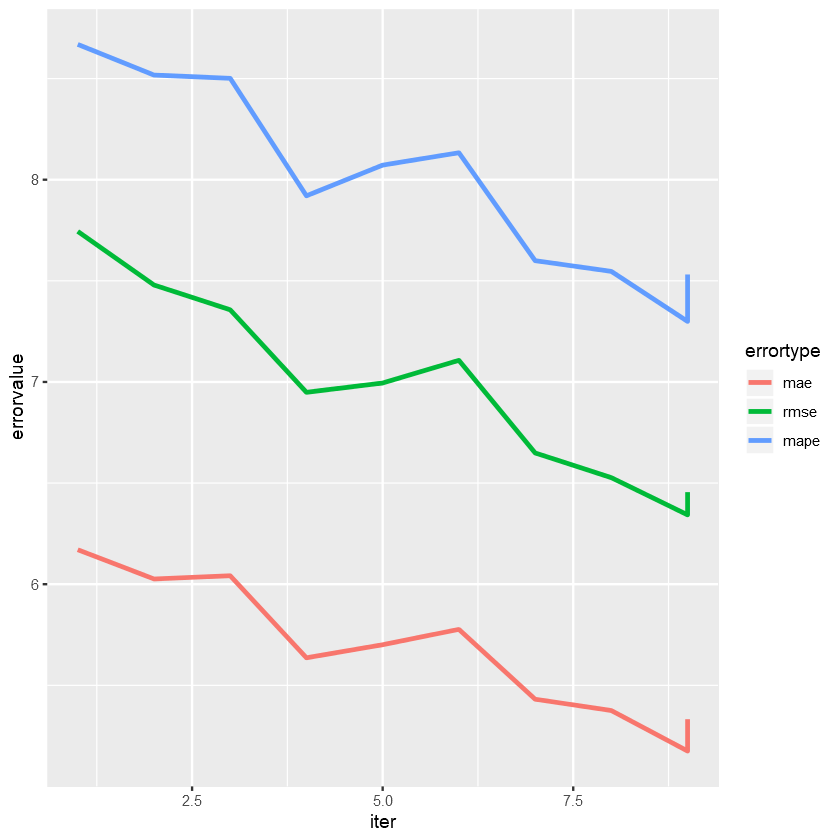

In [65]:
performance_molten_Ad <- melt(data = performance_table_Ad
                             , id.vars = 'iter')
setnames(performance_molten_Ad, c("variable","value"),c("errortype","errorvalue"))
p_Ad = ggplot(performance_molten_Ad, aes(x = iter, y = errorvalue, group=errortype, col=errortype)) + 
            geom_line(lwd=1)
p_Ad

# Random Sampling vs Uncertainty Sampling

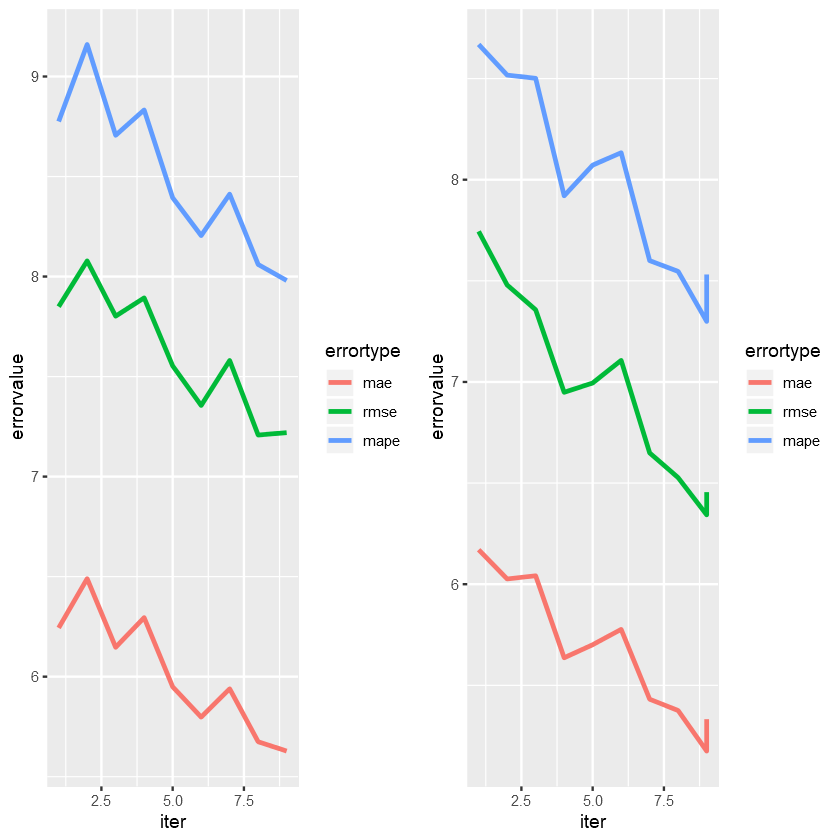

In [67]:
grid.arrange(p_Rd, p_Ad, ncol=2)

# Adaptive Sampling & Feature Elimination 

## Generate Training Set

Select a relatively big data pool ( nofinstances should be medium) , like 400

In [233]:
LHSample_Ad = copy(adaptive_initial_data)

In [ ]:
#if(GenerateTTData == 1){
#   
#    LHSample_Ad = as.data.table(maximinLHS(n = train_ins_Ad, k = nofparams, dup = 5))
#    
#    LHSample_Ad$V1 = qunif(LHSample_Ad$V1, 10, 90) 
#    LHSample_Ad$V2 = qunif(LHSample_Ad$V2, 10, 90) 
#    setnames(LHSample_Ad, c("V1","V2"), feature_names)
#    LHSample_Ad$output <- 0.00
#    
#    paste0("ABM run start time : ",Sys.time())
#    LHSample_Ad = run_ABM(nofrep,train_ins_Ad,LHSample_Ad) %>% as.data.table()
#    paste0("ABM run end time : ",Sys.time())
#    
#    fwrite(LHSample_Ad, paste0("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data",Sys.Date(),".csv"))
#
#}else{
#    LHSample_Ad <- fread("C:/Users/paslanpatir/Desktop/TEZ_v2/LHSample_Ad_Data_04122019.csv")
#    LHSample_Ad <- head(LHSample_Ad[`%-similar-wanted` < 90],300)
#
#}

### Visualization

In [200]:
pca_LHSample_Ad <- princomp(LHSample_Ad[,-c("output")], cor = TRUE, scores = TRUE)

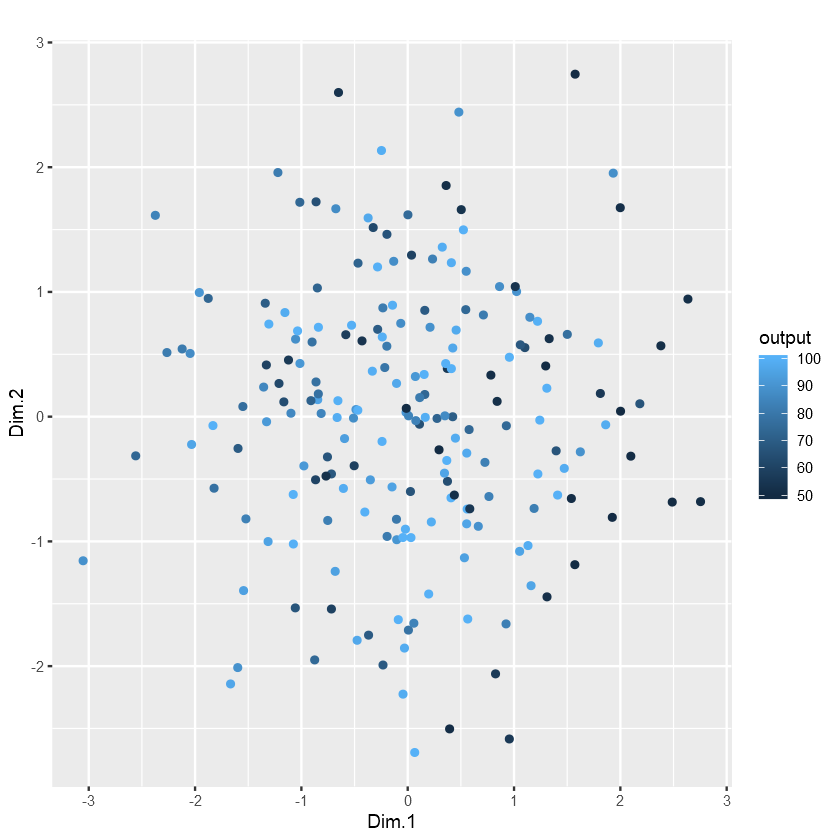

In [201]:
#fviz_pca_ind(pca_LHSample,
#             col.ind = "cos2", # Color by the quality of representation
#             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
#              geom="point"
#             )

pca_LHSample_Ad_components <- get_pca_ind(pca_LHSample_Ad)
pca_LHSample_Ad_components <-cbind(pca_LHSample_Ad_components$coord[,1:2],LHSample_Ad[,c("output")])
p_LHSample_Ad <- ggplot(data = pca_LHSample_Ad_components, aes(x = Dim.1, y = Dim.2)) +
                     geom_point(aes(colour = output)) +
                     labs( title = "", legend = "output") 
p_LHSample_Ad

## Train & Test Metamodel

In [234]:
## initialize record tables
# Record train candidates
train_candidates_table = data.table()

# Record model performances
performance_table = data.table(iter = numeric(), mae= numeric(),rmse= numeric(), mape = numeric()  )

# Record obb_error table
obb_error = data.table(iter = numeric(), obb_error = numeric())

In [235]:
# keep test set undistorted
predictedLabels_table_AdFe = copy(test_set)

## specify variables(columns) to be used
# initialize
columns_left = feature_names
total_numof_eliminated_vars <- 0

iter = 0
h = 1

iteration_history = data.table(iter = numeric(), IsFeatureEliminated = logical(), IsDataSelected = logical())

In [245]:
iter = iter + 1

trainx = LHSample_Ad[,.SD, .SDcols = columns_left]
trainy = LHSample_Ad$output

# Train the model
  model_Sub <- randomForest( x = trainx, y =  trainy,importance = TRUE,ntree = ntree, mtry = mtry)
  assign(paste0("model_Sub_",iter),model_Sub)

if(length(columns_left) == length(feature_names)){
         ranked_features = get_variable_importance(model_Sub)
     }
# Keep training set error records
obb_error = rbind(obb_error,data.table(iter,obb_error_func(model_Sub)),use.names=FALSE)

# Test the model on test set
test_predictions_Sub = get_test_predictions(model_Sub,test_set,error_type)
predictedLabels_Sub = test_predictions_Sub[[1]]
setnames(predictedLabels_Sub,c("pred_output",error_type), c(paste0("pred_output_",iter),paste0(error_type,"_",iter)))  
predictedLabels_table_AdFe = cbind(predictedLabels_table_AdFe,predictedLabels_Sub[,.SD, .SDcols = c(paste0("pred_output_",iter),paste0(error_type,"_",iter))])
 
# Keep test set error records
performance_table = rbind(performance_table,data.table(iter,test_predictions_Sub[[2]]), use.names = FALSE)
 
# update iteration_history
iteration_history = rbind(iteration_history,data.table(iter,0,0),use.names=FALSE)

In [246]:
iteration_history

iter,IsFeatureEliminated,IsDataSelected
<dbl>,<dbl>,<dbl>
1,0,1
2,0,1
3,0,0


In [247]:
## sample selection from unlabeled data
# select candidates
unlabeled_set <- copy(unlabeled_pool)
train_candidates = sample_selection(selected_ins,unlabeled_set,model_Sub)

# eliminate candidates from the unlabeled pool
unlabeled_pool = unlabeled_pool[- train_candidates$idx]
rm(unlabeled_set)

# run ABM to find outputs of train candidates
paste0("ABM train_candidate run start time : ",Sys.time())
train_candidates = run_ABM(nofrep,selected_ins,train_candidates)
paste0("ABM train_candidate run end time : ",Sys.time())

train_candidates_table = rbind(train_candidates_table, data.table(train_candidates, "iter" = iter))

# add labeled candidates to the train data
LHSample_Ad = rbind(LHSample_Ad,train_candidates[,-c("idx")])

# update iteration_history
iteration_history[iter == iter,IsDataSelected := 1 ]

[1] "ABM train_candidate run start time : 2020-01-07 03:01:26"

[1] "ABM train_candidate run end time : 2020-01-07 03:01:33"

In [248]:
## feature elimination
# apply feature elimination
    feature_elimination_result = feature_elimination(h,total_numof_eliminated_vars,ranked_features)

    columns_left = feature_elimination_result[[1]]# 
    eliminated_columns = feature_elimination_result[[4]]#   not necessary
    total_numof_eliminated_vars = as.numeric(feature_elimination_result[2])  
    numof_eliminated_vars = as.numeric(feature_elimination_result[3])#   not necessary 

# update iteration_history
iteration_history["iter" == iter,IsFeatureEliminated := 1 ]

In [249]:
performance_table

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,6.250787,7.828267,8.764918
2,5.974198,7.400336,8.415044
3,5.940061,7.322337,8.335367


In [ ]:
feature_elimination
feature_elimination
sample_selection
sample_selection
sample_selection
feature_elimination
sample_selection


In [250]:
# Final records
FinalTrainData_AdFe = copy(LHSample_Ad)
performance_table_AdFe = copy(performance_table)
train_candidates_table_AdFe  = copy(train_candidates_table)
predictedLabels_table_AdFe = copy(predictedLabels_table)
obb_error_AdFe = copy(obb_error)

In [251]:
nrow(FinalTrainData_AdFe)
performance_table_AdFe
train_candidates_table_AdFe
head(predictedLabels_table_AdFe)
obb_error_AdFe

[1] 215

iter,mae,rmse,mape
<dbl>,<dbl>,<dbl>,<dbl>
1,6.250787,7.828267,8.764918
2,5.974198,7.400336,8.415044
3,5.940061,7.322337,8.335367


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,idx,output,iter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
13.69142,79.24679,4.882207,0.91998449,8.973598e-05,107.78014,515,100.00000,1
54.74058,75.14188,3.014332,0.33424647,8.527155e-05,107.89151,124,59.44577,1
11.74379,80.45336,8.975341,0.58972888,8.137752e-05,98.39805,536,100.00000,1
67.13522,75.83053,2.879819,0.87325509,6.641892e-05,105.59251,159,54.74401,1
86.14010,52.77977,1.697082,0.02388423,4.728572e-05,108.34975,523,95.50380,1
50.40119,66.54958,1.710772,0.34678774,5.129994e-05,109.54256,523,99.03153,2
41.55302,79.90264,8.753459,0.68500238,4.525147e-05,100.36608,154,65.28815,2
38.37974,89.54565,9.964524,0.25821075,9.453912e-05,106.31509,513,53.84170,2
55.49370,89.49027,6.655675,0.01826037,5.203562e-05,97.66010,548,49.77367,2


density,%-similar-wanted,budget-multiplier-dummy,density-multiplier-dummy,noise-dummy,tick-limit,output,pred_output_1,RMSE_1,pred_output_2,...,pred_output_6,RMSE_6,pred_output_7,RMSE_7,pred_output_8,RMSE_8,pred_output_9,RMSE_9,pred_output_9.1,RMSE_9.1
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
89.80781,63.22101,9.559364,0.7183232,9.772682e-05,94.85461,98.62087,78.17541,20.445453,79.01366,...,82.28408,16.3367872,83.23506,15.3858061,82.73619,15.884677,83.63766,14.983208,83.88375,14.7371205
65.95304,27.51730,1.113979,0.4611830,4.533282e-05,91.35383,66.09090,75.87696,9.786068,75.13451,...,75.22387,9.1329752,74.98445,8.8935528,74.52992,8.439027,74.73299,8.642097,73.82892,7.7380242
65.63748,42.72006,7.460221,0.2498248,4.748342e-05,106.60832,86.53810,89.51690,2.978804,88.62514,...,89.23500,2.6968944,89.67442,3.1363191,89.05162,2.513514,89.06389,2.525791,89.29970,2.7616026
49.08474,53.36187,1.029111,0.3209241,2.648540e-05,95.31602,97.06720,92.72250,4.344695,91.72419,...,90.24401,6.8231885,90.28087,6.7863264,89.91191,7.155286,90.69240,6.374797,90.81665,6.2505515
82.31666,32.86349,9.937437,0.7424780,9.336225e-05,91.00066,73.99356,72.45417,1.539392,72.52187,...,73.34670,0.6468601,73.23894,0.7546255,71.86804,2.125523,71.71786,2.275702,73.08185,0.9117107
59.08719,22.26741,5.281372,0.7351098,1.573031e-05,98.78114,63.67668,70.49719,6.820516,69.26034,...,71.65696,7.9802839,71.98764,8.3109638,70.77216,7.095483,71.73206,8.055378,71.03525,7.3585692


iter,obb_error
<dbl>,<dbl>
1,69.64831
2,67.65751
3,68.80881


In [ ]:
#varImpPlot(model_Ad)

In [ ]:
NLQuit()